# Dolphin Species Classifier

## Goal
+ Classify different species of Australian dolphins (Snubfin, Bottlenose, Humpbacks) using convolution neural networks (CNN).
+ Impliment the FastAI approach the CCN. Namely, use the pre-trained low-level features learned from a RESNET architecture (basal arches, curves, edges, etc.), and just train the layer neurons to recognize dolphins higher-order features. 


## Data
I scrapped the dolphin images from Google Images (see the functions below). The images are included in the directory `data/dolphins` ( but you could use the script to re-download your own data with different keywords). 

## Model 
This exercise was inspired by the [Fastai Deep Learning](http://course.fast.ai/lessons/lessons.html) course Lesson 1. In that exercise, we tweak a pre-trained RESNET CNN to classify dogs and cats. I have adapted that lesson for 3 species of dolphins. 

## Dependencies
+ python3
+ `fastai` python library version 0.7 (available [here](https://forums.fast.ai/t/fastai-v0-7-install-issues-thread/24652))
+ nvidia gpu: not strictly necessary but highly highly recommended

In [1]:
%matplotlib inline 
import os
import string
import shutil
from random import sample
from PIL import Image
from matplotlib import pyplot as plt
# run the fastai images
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

# check GPU support: yo
torch.cuda.is_available() 
torch.backends.cudnn.enabled


/home/rob/.local/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.24) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


True

## PART 1: Scrap Google Images (optional)
Here is some code to scrap images. This downloads images into `data/dolphins` training sets, validation sets, and testings sets `train`, `valid` and `test1`. The model EXCEPTs this directory structure.

In [2]:
print("You don't need to do the following: the images are already downloaded and available")
from google_images_download import google_images_download
response = google_images_download.googleimagesdownload()

# Functions
# make a new directory, pass if already exists
def makedir(newdir):
   try:
      os.mkdir(newdir)
   except:
       pass

# resize images, save to new location, as jpeg
def MoveRenameConvert(path_to_file, new_directory, new_name_stem, basewidth = 250):
    # path_to_file: path to existing file to process
    # new_directory: new directory for files
    # new_name_stem: name to add before .jpg and after path_to_new_directory/
   imgtype = path_to_file.split(".")[-1] # get image type (png, jpg,tif)
   path_to_new = new_directory+"/"+new_name_stem+".jpg"
   im = Image.open(path_to_file) # if note jpeg, convert to jpeg
   if not im.mode == 'RGB':
      im = im.convert('RGB')   
   wpercent = (basewidth/float(im.size[0]))
   hsize = int((float(im.size[1])*float(wpercent)))
   im = im.resize((basewidth,hsize), Image.ANTIALIAS)
   im.save(path_to_new, quality=95)
   im.close()
   return path_to_new

def DownloadSearchImagesForFastAI(search_keywords, IMG_PATH, iLimitDownloadedImages = 20):
   makedir("downloads")
   makedir("downloads/tmp")
   train_labels = []
   train_images = []
   val_labels = []
   val_images = []
   test_counter = 0
   test_images = []
   test_labels = []
   # loop through queries
   for species_query in search_keywords:
      name_small = ''.join(ch for ch in species_query if ch not in string.punctuation+" ")[0:7]
      PATH_TMP = "tmp/"+name_small+"/"
      makedir(PATH_TMP)
      # download images
      downloader = response.download({'keywords': species_query, 'limit': str(iLimitDownloadedImages), 'image_directory':PATH_TMP})
      # files to move
      path_files_in = downloader[species_query]
      # directories for model (train,validate,test)
      path_out_train  = IMG_PATH+"train/"+name_small # path to training folder (1/2 of files)
      path_out_val  = IMG_PATH+"valid/"+name_small # path to validation folder (1/4 of files)
      path_out_test1  = IMG_PATH+"test1" # path to test folder (1/4 of files)
      makedir(path_out_train) # make the training directory
      makedir(path_out_val) # make the validation directory
      # randomly sample the training images
      train_imgs = sample(path_files_in,round(len(path_files_in)/2)) # training images
      non_train_imgs = [i for i in path_files_in if i not in train_imgs] # non-trianing images
      val_imgs = sample(non_train_imgs,round(len(non_train_imgs)/2)) # validation images
      test_img = [i for i in non_train_imgs if i not in val_imgs]
      # loop through images: move,resize,convert to jpg, rename
      for i,img in enumerate(train_imgs):
         newimage = MoveRenameConvert(img, path_out_train, name_small+"."+str(i))
         train_images.append(newimage)      
         train_labels.append(name_small)
      for i,img in enumerate(val_imgs):
         newimage = MoveRenameConvert(img, path_out_val, name_small+"."+str(i))
         val_images.append(newimage)      
         val_labels.append(name_small)
      for i,img in enumerate(test_img):   
         newimage = MoveRenameConvert(img, path_out_test1, str(test_counter))
         test_images.append(newimage)
         test_labels.append(name_small)
         test_counter +=1
      print("DONE %s. See train images in %s, test images in %s, validation images in %s" % (species_query, path_out_train, path_out_test1, path_out_val))
      # delete the temporary downloaded files
      for f in path_files_in:
         os.remove(f)
      # remove the temporary directoyr
      os.rmdir("downloads/"+PATH_TMP)
   # DONE: remove the final download directory
   os.rmdir("downloads/tmp")
   os.rmdir("downloads")
   print("DONE downloading and processing all images")
   return train_images, train_labels, val_images, val_labels, test_images, test_labels


You don't need to do the following: the images are already downloaded and available


In [2]:
IMG_PATH = "data/dolphins/"

iLimitDownloadedImages = 40 # maximum number of images per species to download

# keywords which demarks different species
search_keywords = ['snubfin dolphin','humpback dolphin', '"bottlenose dolphin" tursiops']

# download images
train_images, train_labels, val_images, val_labels, test_images, test_labels = DownloadSearchImagesForFastAI(search_keywords, IMG_PATH, iLimitDownloadedImages)


NameError: name 'DownloadSearchImagesForFastAI' is not defined

## PART 2: Model Training
Model descriptions from _fastai_
We're going to use a pre-trained model, that is, a model created by some one else to solve a different problem. Instead of building a model from scratch to solve a similar problem, we'll use a model trained on ImageNet (1.2 million images and 1000 classes) as a starting point. The model is a Convolutional Neural Network (CNN), a type of Neural Network that builds state-of-the-art models for computer vision. We'll be learning all about CNNs during this course.

We will be using the resnet34 model. resnet34 is a version of the model that won the 2015 ImageNet competition. Here is more info on resnet models. We'll be studying them in depth later, but for now we'll focus on using them effectively.

### Data Augmentation
We will use data augmentation (rotating around an axis, zooming) to ensure that the CNN learns general features that are invariant to whether the images is from the left or right

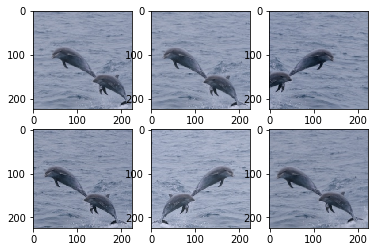

In [3]:
# PATH is the path to your data - if you use the recommended setup approaches from the lesson, you won't need to change this. sz is the size that the images will be resized to in order to ensure that the training runs quickly. We'll be talking about this parameter a lot during the course. Leave it at 224 for now.
PATH = "data/dolphins/"
sz=224 # resize of image for CNN
arch=resnet34 # model architecture

# Data Augmentation: flip the images on vertical axis plus magnification
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=4, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

ims = np.stack([get_augs() for i in range(6)])

plt.figure(1)
plt.subplot(231)
plt.imshow(ims[0])
plt.subplot(232)
plt.imshow(ims[1])
plt.subplot(233)
plt.imshow(ims[2])
plt.subplot(234)
plt.imshow(ims[3])
plt.subplot(235)
plt.imshow(ims[4])
plt.subplot(236)
plt.imshow(ims[5])
plt.show()

## Pre-trained features or update deep weights?
The RESNET model has finely tuned deep layers that haved learned a hierarchy of visual features (archs, edges, shapes, objects). Should we update this deep layers which are already so good at classification and object detection? Perhaps... especially because the dolphins are very similar is overall shape. 
+ pros: we could learn dolphin-specific features
+ cons: we have a small dataset and could disrupt the _general_ feature learning and _overfit_ our images.

Let's try each of them out

In [40]:
# get the data (from path)
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
# use the pre-learned features from RESNET (very good at finding features, no great need to train, except the last layer)
mod_final = ConvLearner.pretrained(arch, data, precompute=True)

# first learner: just learn the final layer (takes low- and mid-level features to train onto final dolphins species ID)
mod_final.fit(0.03, 10)

/home/rob/.local/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/rob/.local/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


epoch      trn_loss   val_loss   accuracy                                                            
    0      1.446567   1.163171   0.413793  
    1      1.34738    1.101147   0.37931                                                             
    2      1.195264   1.049741   0.517241                                                            
    3      1.041371   1.016848   0.551724                                                            
    4      0.911702   0.989355   0.482759                                                            
    5      0.785427   0.967825   0.551724                                                            
    6      0.692126   0.949737   0.551724                                                            
    7      0.619678   0.934586   0.551724                                                            
    8      0.556032   0.926962   0.551724                                                            
    9      0.507565   0.922391   0.586

[0.9223911166191101, 0.5862069129943848]

We see that the validation accuracy is quite bad. But, there is a big difference between the training loss (first column, low) and the validation loss (higher, and perhaps increasing). This may mean we are overfitting. Can we re-learn some of the deeper layers to tweak the basal-features to help learn shapes that are more meaningful for dolphins?

### Unfreezing the deep layers: Basal Learning
It is probably a bad idea to relearn the Basal layers totally (after all, we don't have a lot of data). Fortunately, we can go midway: just tweak the basal layers slightly, through a little backpropagation, while updating agressively the final layers. This is called Differential Learning Rates, popularized by Fastai. 

We do this by first running `precompute=False` then `unfreeze()` to allow updating of the basal layers. Finally, we set the differential learning rates with `lr=np.array([0.0005,0.0008,0.014])`: the numbers on the left are the (low) learning rate for the deep basal features, and the latter number is for the final layers. This way, we try not to disturb the well-trained basal features, but merely tweak them for our dolphin specific case.

We are also going to decrease the learning rates.

In [41]:
# first model: train the last layer only
mod_final.precompute=False
mod_final.fit(0.03, 3, cycle_len=1,cycle_mult=2)

#Fine-tuning and differential learning rate annealing
#Now that we have a good final layer trained, we can try fine-tuning the other layers. To tell the learner that we want to unfreeze the remaining layers, just call (surprise surprise!) unfreeze().
mod_final.unfreeze()
lr=np.array([0.0005,0.001,0.03])
mod_final.fit(lr, 3, cycle_len=2, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                            
    0      0.189547   0.892774   0.586207  
    1      0.186998   0.870786   0.586207                                                            
    2      0.178913   0.844997   0.62069                                                             
    3      0.181576   0.829851   0.62069                                                             
    4      0.17329    0.812561   0.655172                                                            
    5      0.165164   0.799061   0.655172                                                            
    6      0.158907   0.77964    0.655172                                                            



epoch      trn_loss   val_loss   accuracy                                                            
    0      0.548404   0.752454   0.689655  
    1      0.472972   0.737209   0.689655                                                            
    2      0.429148   0.731055   0.689655                                                            
    3      0.422886   0.737799   0.689655                                                            
    4      0.412489   0.753979   0.655172                                                            
    5      0.390033   0.766058   0.62069                                                             
    6      0.376498   0.791646   0.655172                                                            
    7      0.361174   0.821104   0.689655                                                            
    8      0.339165   0.849478   0.655172                                                            
    9      0.321392   0.871694   0.655

[0.8868496417999268, 0.6551724076271057]

## Confusion Matrix

Confusion matrix on the VALIDATION data
[[7 2 1]
 [1 7 2]
 [2 2 5]]


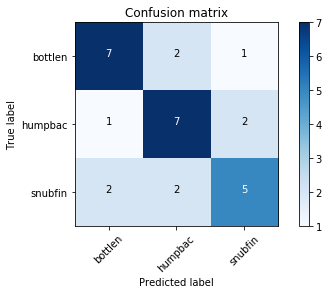

the validation accuracy is  0.655


In [42]:
from sklearn.metrics import confusion_matrix
# predict the classes of the validation data
log_preds = mod_final.predict()
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds)  # probabilities

# make a confusion matrix
y = data.val_y
cm = confusion_matrix(y, preds)
print("Confusion matrix on the VALIDATION data")
plot_confusion_matrix(cm, data.classes)
plt.show()
acc_val = sum(1*(preds == y))/len(preds)
print("the validation accuracy is % 0.3f" % acc_val)



## Visualize Difficult Cases
A great part of the fast ai course is Jeremy's suggesting to plot the successful and failed classification cases.

Overall the conclusions are:
+ our validation data is contaminated with some crappy images (watermarks)
+ the worst cases have idiosyncratic features (dead snubfin, watermarks, murky water)

In [43]:
# PLotting functions from Fast.ai
def most_by_correct(label, is_correct):
   if is_correct:
      ix = np.where((preds == label) & (data.val_y == label))[0]
      tpfp = -1*probs[ix,label]
   else:
      ix = np.where((preds != label) & (data.val_y == label))[0]
      tpfp = probs[ix,label]
   return ix[np.argsort(tpfp)][0:min(5,len(ix))]

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')


correct bottlenose


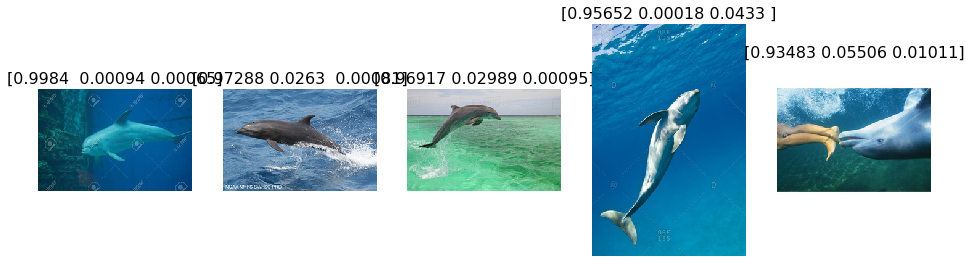

In [44]:
from matplotlib import pyplot as plt
plot_val_with_title(most_by_correct(0, True), "correct bottlenose") 
plt.show()


incorrect bottlenose


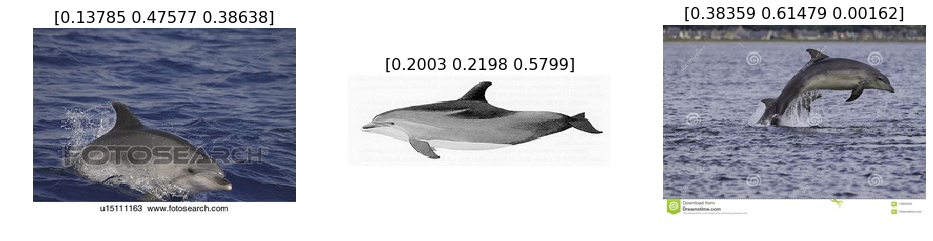

In [45]:
plot_val_with_title(most_by_correct(0, False), "incorrect bottlenose") 
plt.show()


correct humpbacks


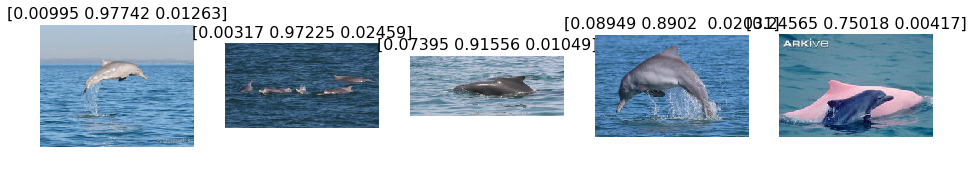

In [46]:
plot_val_with_title(most_by_correct(1, True), "correct humpbacks")
plt.show()


incorrect humpbacks


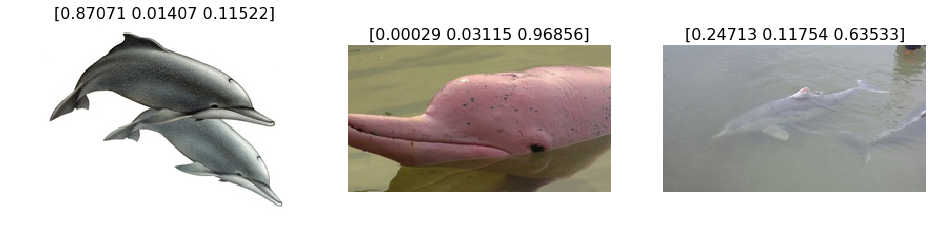

In [47]:
plot_val_with_title(most_by_correct(1, False), "incorrect humpbacks")
plt.show()


correct snubbies


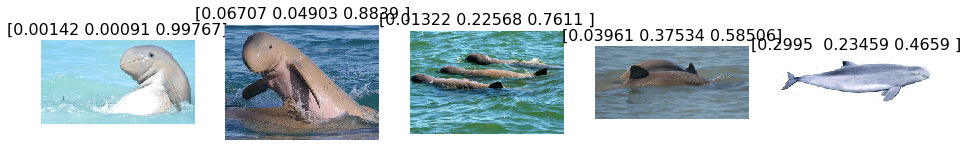

In [48]:
plot_val_with_title(most_by_correct(2, True), "correct snubbies")
plt.show()


incorrect snubbies


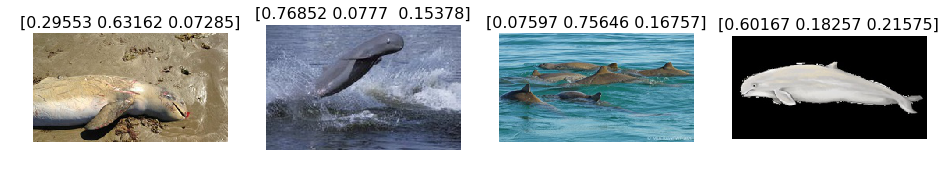

In [49]:
plot_val_with_title(most_by_correct(2, False), "incorrect snubbies")
plt.show()


## Part 3: Test Set
Finally, we will test on a hold-out set of data.
This may seem redundant to the above, but we were using the validation images to judge some hyperparameters, whereas the test data was not used in any way to inform the model building, thus, it is a _fair_ assessment set.

[[10  0  0]
 [ 2  7  1]
 [ 2  2  6]]
Final confusion on out-of-sample data


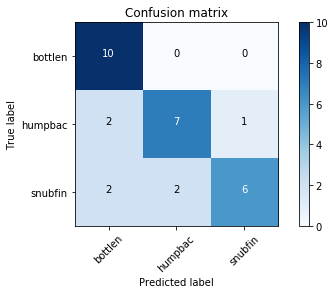

the out-of-sample accuracy is  0.767


In [50]:
test_files = os.listdir(PATH+"test1")
test_files.sort()
test_files_number = [int(i.split(".")[0]) for i in test_files] # image numbers
test_labels = [(2 if i < 10 else (1 if (i >= 10) & (i < 20) else 0)) for i in test_files_number] # assign labels (0:9 are snubbies, 10:19 are humpbacks, 20:29 are bottlenose)
test_eng_labels = ["bottlenose" if k==0 else ("humpback" if k==1 else "snubbies") for k in test_labels]

# load new images and test
trn_tfms, val_tfms = tfms_from_model(arch,sz)
#ds = FilesIndexArrayDataset(test_files,np.array([i for i in range(0,len(test_files))]),val_tfms,PATH+"test1/")
ds = FilesIndexArrayDataset(test_files,np.array(test_files_number),val_tfms,PATH+"test1/")
test_dl = DataLoader(ds)
test_preds = mod_final.predict_dl(test_dl)
test_predy = np.argmax(test_preds,axis = 1)

cm = confusion_matrix(test_labels, test_predy)
plot_confusion_matrix(cm, data.classes)
print("Final confusion on out-of-sample data")
plt.show()
acc_test = sum(1*(test_predy == test_labels))/len(test_preds)
print("the out-of-sample accuracy is % 0.3f" % acc_test)



## Conclusions
+ there is high confusion between bottlenose and humpbacks
+ snubies are well defined
+ some of the confused images are due to idiosyncratic corruptions to the images (watermarks, dead animal)
+ for this dataset, the pretrain deep features seemed better than learning deep features on a small dataset.